In [46]:
# Import all the libraries we need
from pathlib import Path
import os, json
from collections import Counter, defaultdict

import numpy as np
from skimage import io, color, transform, feature

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import matplotlib.pyplot as plt

# Setup paths to our data
NB_DIR = Path().resolve()  
REPO_ROOT = NB_DIR.parent.parent  # go up 2 folders

# where our images are stored
TRAIN_DIR = REPO_ROOT / "Image Datasets" / "PreProcessing" / "processed-image-dataset-u" / "train"
TEST_DIR  = REPO_ROOT / "Image Datasets" / "PreProcessing" / "processed-image-dataset-u" / "test"

# create results folder to save outputs
RESULTS_DIR = NB_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# check if paths are correct
print("Notebook dir:", NB_DIR)
print("Repo root:", REPO_ROOT)
print("Train exists?", TRAIN_DIR.exists())
print("Test exists?", TEST_DIR.exists())

# get all the class names from train folder
if TRAIN_DIR.exists():
    CLASSES = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
    print("Classes:", CLASSES)
else:
    print("ERROR: Can't find training directory!")

Notebook dir: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline
Repo root: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main
Train exists? True
Test exists? True
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


In [47]:
from collections import Counter

# file extensions we want to load
EXTS = {".jpg", ".jpeg", ".png", ".JPG", ".PNG", ".JPEG"}

def count_images(folder):
    """Count how many images in each class folder"""
    counts = {}
    for cls_folder in sorted([p for p in folder.iterdir() if p.is_dir()]):
        # count files with image extensions
        num_images = sum(1 for f in cls_folder.rglob("*") if f.suffix in EXTS)
        counts[cls_folder.name] = num_images
    return counts

# count images in train and test sets
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("Train counts:")
for cls, count in train_counts.items():
    print(f"  {cls:30s} {count}")

print("\nTest counts:")
for cls, count in test_counts.items():
    print(f"  {cls:30s} {count}")

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
print(f"\nTotal train: {total_train} | Total test: {total_test}")

Train counts:
  Potato___Early_blight          702
  Potato___healthy               931
  Potato___Late_blight           701
  Tomato_Bacterial_spot          1488
  Tomato_Early_blight            700
  Tomato_healthy                 1121
  Tomato_Late_blight             1336

Test counts:
  Potato___Early_blight          300
  Potato___healthy               400
  Potato___Late_blight           300
  Tomato_Bacterial_spot          639
  Tomato_Early_blight            300
  Tomato_healthy                 478
  Tomato_Late_blight             573

Total train: 6979 | Total test: 2990


In [48]:
import numpy as np
from skimage import io, color, transform, feature

# resize all images to same size
IMG_SIZE = (224, 224)

# HOG feature parameters
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

def img_to_features(path):
    """
    Extract features from an image file
    Returns: combined HOG and color histogram features
    """
    # load image
    img = io.imread(path)
    
    # convert grayscale to RGB if needed
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    
    # remove alpha channel if present
    if img.shape[-1] == 4:
        img = img[:, :, :3]
    
    # resize to standard size and normalize to 0-1
    img = transform.resize(img, IMG_SIZE, anti_aliasing=True, preserve_range=True)
    img = img.astype('float32') / 255.0
    
    # extract HOG features from grayscale
    gray = color.rgb2gray(img)
    hog_vec = feature.hog(gray, **HOG_PARAMS)
    
    # extract color histograms (16 bins per channel)
    hist_r, _ = np.histogram(img[:, :, 0], bins=16, range=(0, 1), density=True)
    hist_g, _ = np.histogram(img[:, :, 1], bins=16, range=(0, 1), density=True)
    hist_b, _ = np.histogram(img[:, :, 2], bins=16, range=(0, 1), density=True)
    
    # combine all color histograms
    color_hist = np.concatenate([hist_r, hist_g, hist_b])
    
    # return combined feature vector
    return np.concatenate([hog_vec, color_hist])

In [49]:
EXTS = {".jpg", ".jpeg", ".png", ".JPG", ".PNG", ".JPEG"}

def load_split(folder):
    """Load all images from a folder and extract features"""
    X = []  # features
    y = []  # labels
    paths = []  # image paths for reference
    
    class_dirs = sorted([p for p in folder.iterdir() if p.is_dir()])
    
    for cls_dir in class_dirs:
        for img_path in cls_dir.rglob("*"):
            # skip non-image files
            if img_path.suffix not in EXTS:
                continue
            
            try:
                # extract features and store
                features = img_to_features(img_path)
                X.append(features)
                y.append(cls_dir.name)
                paths.append(str(img_path))
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    
    # convert lists to numpy arrays
    X = np.vstack(X)
    y = np.array(y)
    
    return X, y, paths

# paths to save/load cached features
Xtr_path = RESULTS_DIR / "features_train.npy"
ytr_path = RESULTS_DIR / "labels_train.npy"
Xte_path = RESULTS_DIR / "features_test.npy"
yte_path = RESULTS_DIR / "labels_test.npy"
meta_path = RESULTS_DIR / "features_meta.json"

# check if we need to recompute features
need_recompute = not (Xtr_path.exists() and ytr_path.exists() and 
                      Xte_path.exists() and yte_path.exists())

if need_recompute:
    print("Extracting features from training images...")
    X_train, y_train, train_paths = load_split(TRAIN_DIR)
    
    print("Extracting features from test images...")
    X_test, y_test, test_paths = load_split(TEST_DIR)
    
    # save features to disk for faster loading next time
    np.save(Xtr_path, X_train)
    np.save(ytr_path, y_train)
    np.save(Xte_path, X_test)
    np.save(yte_path, y_test)
    
    # save metadata
    import json
    meta = {
        'img_size': (224, 224),
        'hog_params': HOG_PARAMS,
        'classes': CLASSES,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)
    
    print(f"Features saved to: {RESULTS_DIR}")
else:
    # load pre-computed features
    print(f"Loading cached features from: {RESULTS_DIR}")
    X_train = np.load(Xtr_path)
    y_train = np.load(ytr_path, allow_pickle=True)
    X_test = np.load(Xte_path)
    y_test = np.load(yte_path, allow_pickle=True)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Extracting features from training images...
Extracting features from test images...
Features saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results
X_train shape: (6979, 26292)
X_test shape: (2990, 26292)


In [50]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

print("="*60)
print("PREPROCESSING DATA")
print("="*60)

# Step 1: Encode labels (convert class names to numbers)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("\nLabel Encoding:")
for i, cls in enumerate(le.classes_):
    print(f"  {i}: {cls}")

# Step 2: Scale features (make mean=0 and std=1)
# This is important for KNN and Naive Bayes
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print("\nFeature scaling done!")
print(f"Training data: {X_train.shape} -> {X_train_sc.shape}")
print(f"Test data: {X_test.shape} -> {X_test_sc.shape}")
print(f"Training labels: {y_train.shape} -> {y_train_enc.shape}")
print(f"Test labels: {y_test.shape} -> {y_test_enc.shape}")
print("="*60)

PREPROCESSING DATA

Label Encoding:
  0: Potato___Early_blight
  1: Potato___Late_blight
  2: Potato___healthy
  3: Tomato_Bacterial_spot
  4: Tomato_Early_blight
  5: Tomato_Late_blight
  6: Tomato_healthy

Feature scaling done!
Training data: (6979, 26292) -> (6979, 26292)
Test data: (2990, 26292) -> (2990, 26292)
Training labels: (6979,) -> (6979,)
Test labels: (2990,) -> (2990,)


In [51]:
import time

print("="*60)
print("TRAINING BASELINE MODELS")
print("="*60)

# Setup the 3 models we're testing
models = {
    "Naive Bayes": GaussianNB(var_smoothing=1e-9),
    
    "Decision Tree": DecisionTreeClassifier(
        criterion='gini',
        max_depth=30,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'  # helps with imbalanced classes
    ),
    
    "KNN": KNeighborsClassifier(
        n_neighbors=7,  # chose 7 to avoid ties
        weights='distance',
        metric='euclidean',
        n_jobs=-1  # use all cores for faster training
    )
}

# Train each model and track time
fitted = {}
training_times = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    start = time.time()
    model.fit(X_train_sc, y_train_enc)
    end = time.time()
    
    training_times[name] = end - start
    fitted[name] = model
    
    print(f"  Done! Took {training_times[name]:.2f} seconds")

print("\n" + "="*60)
print("All models trained!")

TRAINING BASELINE MODELS

Training Naive Bayes...
  Done! Took 7.53 seconds

Training Decision Tree...
  Done! Took 8.94 seconds

Training KNN...
  Done! Took 0.47 seconds

All models trained!


In [52]:
print("\n" + "="*60)
print("MODEL SETUP EXPLANATION")
print("="*60)

# Naive Bayes
print("\nNaive Bayes:")
print("  - Uses Gaussian (normal) distribution assumption")
print("  - var_smoothing=1e-9 prevents division by zero errors")
print("  - Fast training, good for high-dimensional data")
print("  - Limitation: assumes features are independent")

# Decision Tree  
print("\nDecision Tree:")
print("  - Gini impurity used to split nodes")
print("  - max_depth=30: deep enough to learn patterns but not overfit")
print("  - min_samples_split=5: need at least 5 samples to make a split")
print("  - min_samples_leaf=2: leaf nodes must have 2+ samples")
print("  - max_features='sqrt': only look at sqrt(features) per split")
print("  - class_weight='balanced': handle our imbalanced dataset")
print("  - Good for interpretability and non-linear patterns")

# KNN
print("\nKNN:")
print("  - k=7: odd number to avoid ties in voting")
print("  - weights='distance': closer neighbors count more")
print("  - metric='euclidean': standard distance measure")
print("  - n_jobs=-1: use all CPU cores for speed")
print("  - Good for local patterns, but slower on large datasets")

print("\n" + "="*60)


MODEL SETUP EXPLANATION

Naive Bayes:
  - Uses Gaussian (normal) distribution assumption
  - var_smoothing=1e-9 prevents division by zero errors
  - Fast training, good for high-dimensional data
  - Limitation: assumes features are independent

Decision Tree:
  - Gini impurity used to split nodes
  - max_depth=30: deep enough to learn patterns but not overfit
  - min_samples_split=5: need at least 5 samples to make a split
  - min_samples_leaf=2: leaf nodes must have 2+ samples
  - max_features='sqrt': only look at sqrt(features) per split
  - class_weight='balanced': handle our imbalanced dataset
  - Good for interpretability and non-linear patterns

KNN:
  - k=7: odd number to avoid ties in voting
  - weights='distance': closer neighbors count more
  - metric='euclidean': standard distance measure
  - n_jobs=-1: use all CPU cores for speed
  - Good for local patterns, but slower on large datasets



In [53]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report
)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance on train and test data
    Returns dictionary with all metrics needed for R3
    """
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get probabilities if model supports it
    try:
        y_test_proba = model.predict_proba(X_test)
    except:
        y_test_proba = None
    
    # Calculate accuracy on both train and test
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Macro metrics - treats all classes equally
    prec_macro = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    
    # Weighted metrics - accounts for class imbalance
    prec_weighted = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    prec_per_class = precision_score(y_test, y_test_pred, average=None, zero_division=0)
    rec_per_class = recall_score(y_test, y_test_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_test, y_test_pred, average=None, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Check for overfitting
    overfit_gap = train_acc - test_acc
    
    return {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'overfit_gap': overfit_gap,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro,
        'f1_macro': f1_macro,
        'precision_weighted': prec_weighted,
        'recall_weighted': rec_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': prec_per_class,
        'recall_per_class': rec_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'y_pred': y_test_pred,
        'y_proba': y_test_proba
    }

# Evaluate all our models
print("="*60)
print("EVALUATING MODELS")
print("="*60)

results = {}
for name, model in fitted.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train_sc, y_train_enc, X_test_sc, y_test_enc)
    print(f"  Test Accuracy: {results[name]['test_accuracy']:.4f}")

print("\n" + "="*60)

EVALUATING MODELS

Evaluating Naive Bayes...
  Test Accuracy: 0.6545

Evaluating Decision Tree...
  Test Accuracy: 0.4689

Evaluating KNN...
  Test Accuracy: 0.2639



In [54]:
import pandas as pd
import numpy as np

# Create results table
rows = []
for name, res in results.items():
    rows.append({
        'Model': name,
        'Train Acc': f"{res['train_accuracy']:.4f}",
        'Test Acc': f"{res['test_accuracy']:.4f}",
        'Overfit Gap': f"{res['overfit_gap']:.4f}",
        'Precision (M)': f"{res['precision_macro']:.4f}",
        'Recall (M)': f"{res['recall_macro']:.4f}",
        'F1-Score (M)': f"{res['f1_macro']:.4f}",
        'Precision (W)': f"{res['precision_weighted']:.4f}",
        'Recall (W)': f"{res['recall_weighted']:.4f}",
        'F1-Score (W)': f"{res['f1_weighted']:.4f}"
    })

results_df = pd.DataFrame(rows)

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print("\n(M) = Macro-averaged | (W) = Weighted")
print()
print(results_df.to_string(index=False))
print("="*60)

# Find best performing model
best_model = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
best_acc = results[best_model]['test_accuracy']

print(f"\nBest Model: {best_model} with Test Accuracy: {best_acc:.4f}")

# Check for overfitting issues
print("\nOverfitting Check:")
for name, res in results.items():
    gap = res['overfit_gap']
    if gap > 0.10:
        print(f"  {name}: Possible overfitting (gap = {gap:.4f})")
    elif gap < 0.05:
        print(f"  {name}: Good generalization (gap = {gap:.4f})")
    else:
        print(f"  {name}: Acceptable (gap = {gap:.4f})")

# Save results
results_df.to_csv(RESULTS_DIR / "baseline_results.csv", index=False)
print(f"\nResults saved to: {RESULTS_DIR / 'baseline_results.csv'}")


MODEL PERFORMANCE SUMMARY

(M) = Macro-averaged | (W) = Weighted

        Model Train Acc Test Acc Overfit Gap Precision (M) Recall (M) F1-Score (M) Precision (W) Recall (W) F1-Score (W)
  Naive Bayes    0.6896   0.6545      0.0351        0.6627     0.6545       0.6420        0.6887     0.6545       0.6541
Decision Tree    0.9252   0.4689      0.4563        0.4609     0.4572       0.4581        0.4800     0.4689       0.4735
          KNN    1.0000   0.2639      0.7361        0.5680     0.2345       0.1927        0.5583     0.2639       0.2169

Best Model: Naive Bayes with Test Accuracy: 0.6545

Overfitting Check:
  Naive Bayes: Good generalization (gap = 0.0351)
  Decision Tree: Possible overfitting (gap = 0.4563)
  KNN: Possible overfitting (gap = 0.7361)

Results saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\baseline_results.csv


In [55]:
print("\n" + "="*60)
print("PER-CLASS PERFORMANCE")
print("="*60)

class_names = le.classes_

for name, res in results.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    
    # Build table with per-class metrics
    per_class_data = []
    for i, cls in enumerate(class_names):
        per_class_data.append({
            'Class': cls,
            'Precision': f"{res['precision_per_class'][i]:.4f}",
            'Recall': f"{res['recall_per_class'][i]:.4f}",
            'F1-Score': f"{res['f1_per_class'][i]:.4f}",
            'Support': int((y_test_enc == i).sum())
        })
    
    per_class_df = pd.DataFrame(per_class_data)
    print("\n" + per_class_df.to_string(index=False))
    
    # Find best and worst classes
    f1_scores = res['f1_per_class']
    best_idx = np.argmax(f1_scores)
    worst_idx = np.argmin(f1_scores)
    
    print(f"\nBest: {class_names[best_idx]} (F1: {f1_scores[best_idx]:.4f})")
    print(f"Worst: {class_names[worst_idx]} (F1: {f1_scores[worst_idx]:.4f})")
    
    # Save to CSV
    filename = f"per_class_{name.replace(' ', '_').lower()}.csv"
    per_class_df.to_csv(RESULTS_DIR / filename, index=False)

print("\n" + "="*60)


PER-CLASS PERFORMANCE

Naive Bayes

                Class Precision Recall F1-Score  Support
Potato___Early_blight    0.7202 0.8067   0.7610      300
 Potato___Late_blight    0.4688 0.6500   0.5447      300
     Potato___healthy    0.9300 0.5975   0.7275      400
Tomato_Bacterial_spot    0.7758 0.7527   0.7641      639
  Tomato_Early_blight    0.3776 0.4933   0.4277      300
   Tomato_Late_blight    0.7169 0.4154   0.5260      573
       Tomato_healthy    0.6499 0.8661   0.7426      478

Best: Tomato_Bacterial_spot (F1: 0.7641)
Worst: Tomato_Early_blight (F1: 0.4277)

Decision Tree

                Class Precision Recall F1-Score  Support
Potato___Early_blight    0.6179 0.5767   0.5966      300
 Potato___Late_blight    0.2377 0.2900   0.2613      300
     Potato___healthy    0.5700 0.5700   0.5700      400
Tomato_Bacterial_spot    0.5696 0.4992   0.5321      639
  Tomato_Early_blight    0.2238 0.2567   0.2391      300
   Tomato_Late_blight    0.3978 0.3805   0.3889      573
       Tom


CONFUSION MATRICES

Naive Bayes:


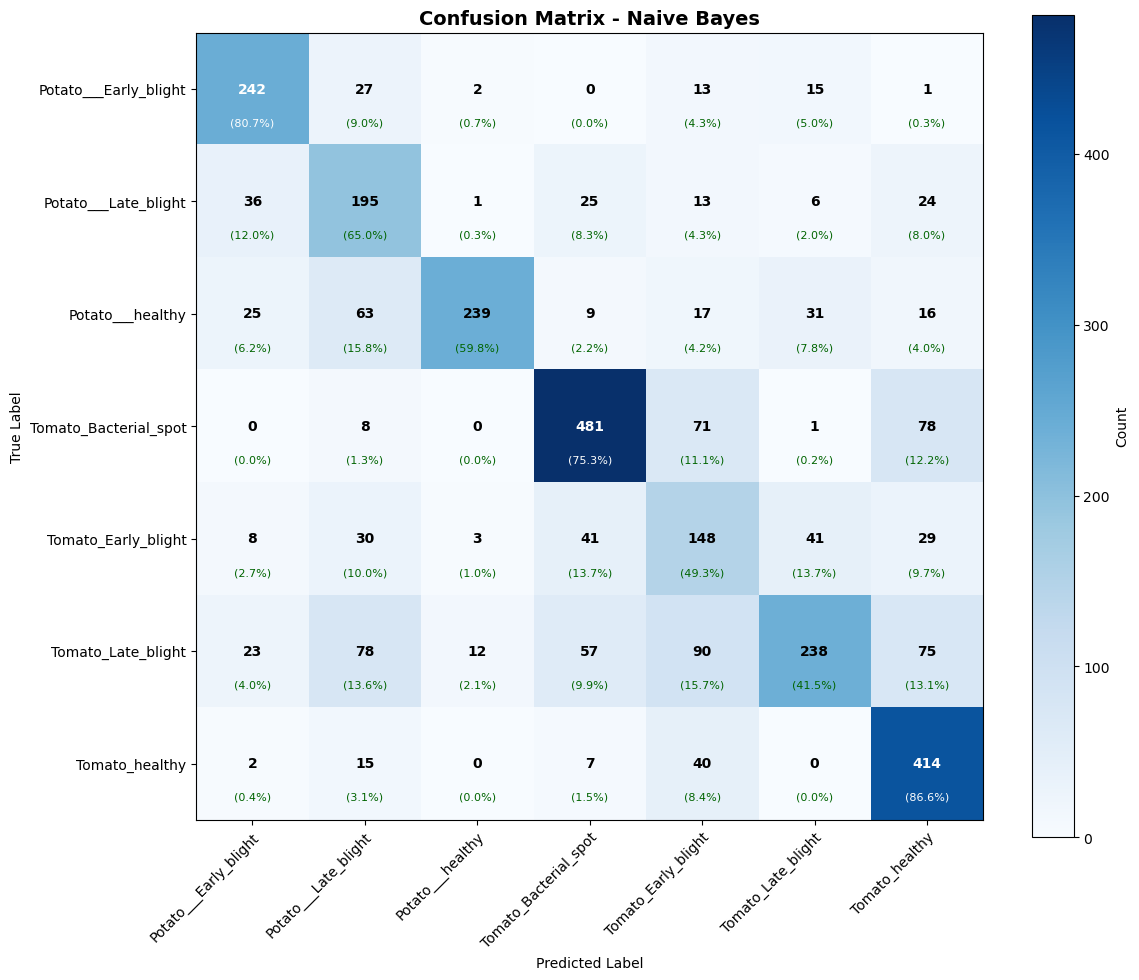

Naive Bayes Accuracy: 0.6545
Saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\confusion_matrix_naive_bayes.png


Decision Tree:


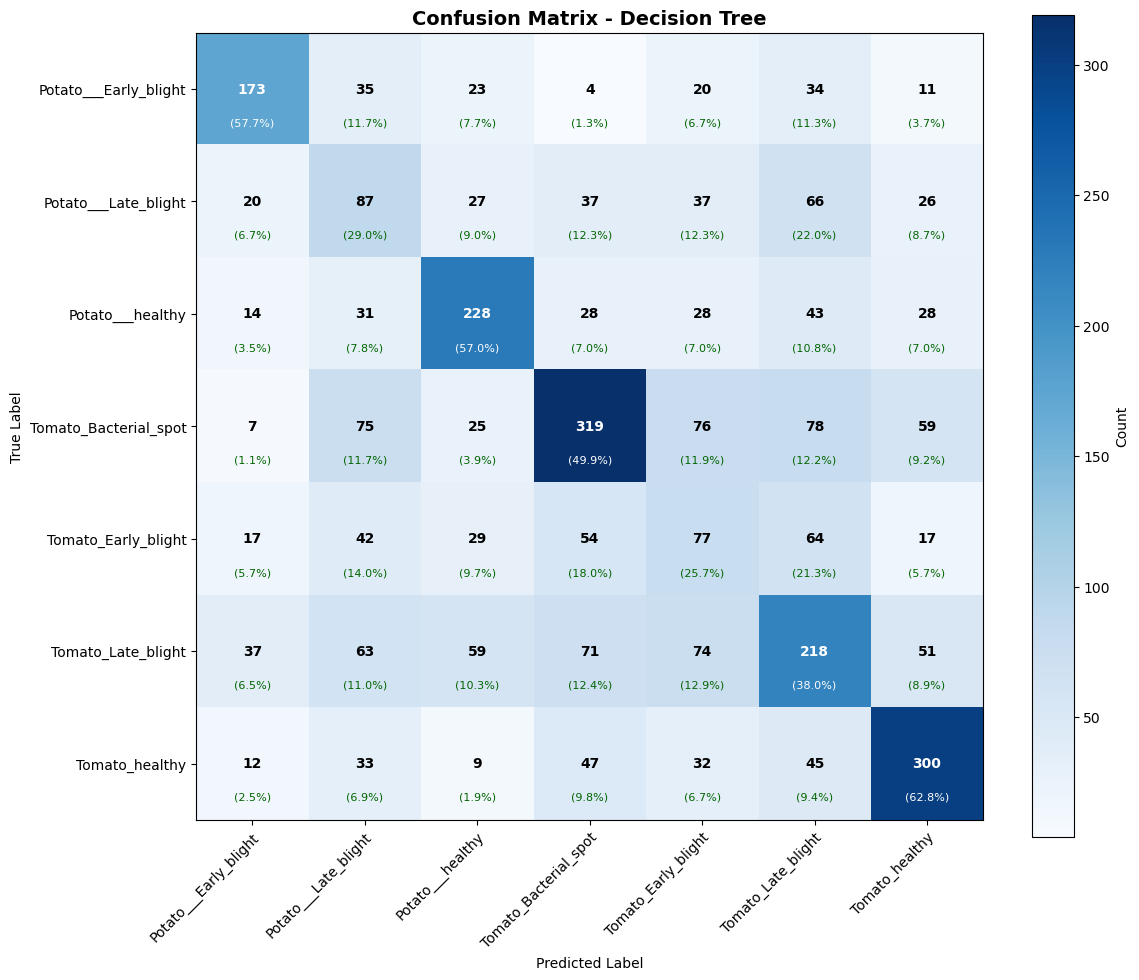

Decision Tree Accuracy: 0.4689
Saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\confusion_matrix_decision_tree.png


KNN:


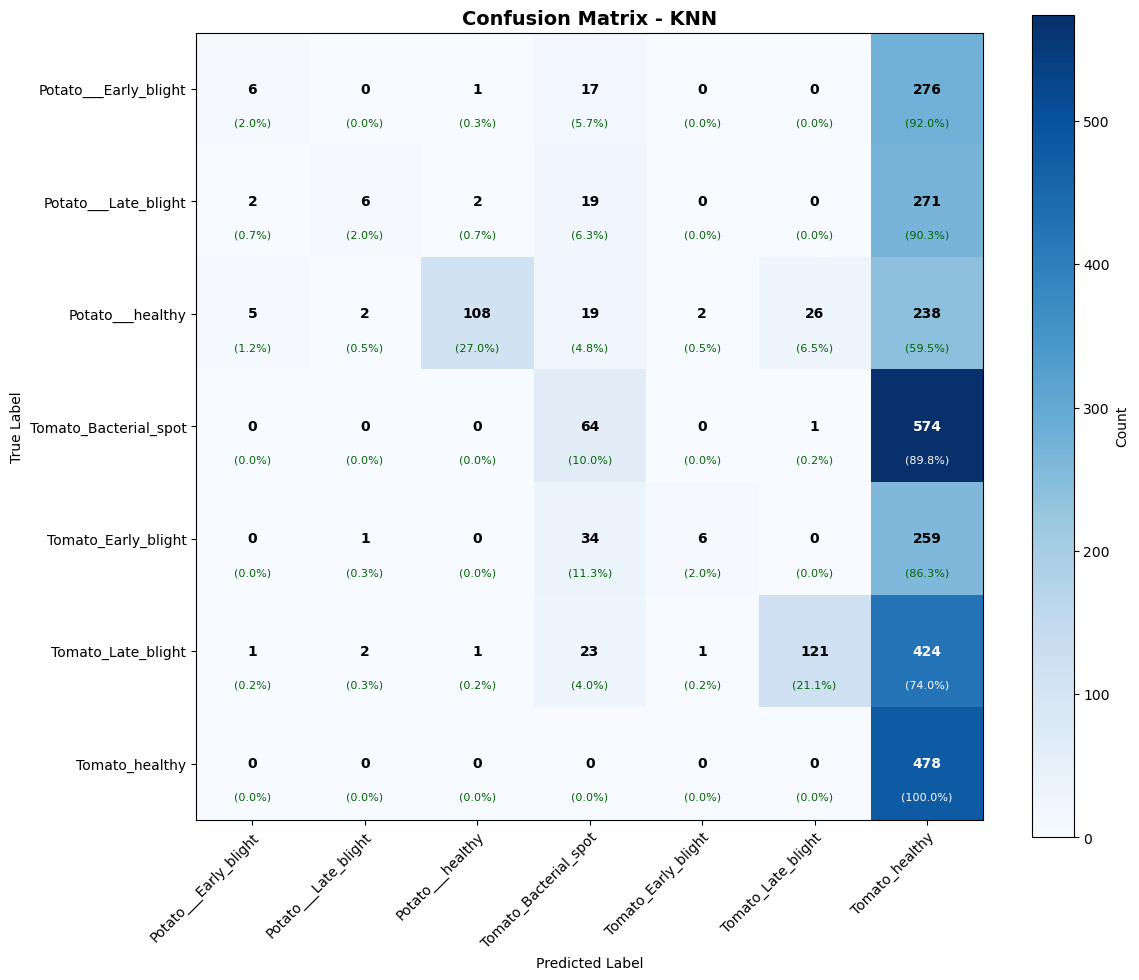

KNN Accuracy: 0.2639
Saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\confusion_matrix_knn.png



In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, model_name, save_path):
    """Plot confusion matrix with counts and percentages"""
    
    # Calculate percentages for each row
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax, label='Count')
    
    # Setup axes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, 
           yticklabels=class_names,
           ylabel='True Label',
           xlabel='Predicted Label')
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    threshold = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Show count
            text_color = "white" if cm[i, j] > threshold else "black"
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color=text_color,
                   fontsize=10, fontweight='bold')
            
            # Show percentage below count
            pct = cm_percent[i, j] * 100
            pct_color = "white" if cm[i, j] > threshold else "darkgreen"
            ax.text(j, i + 0.3, f'({pct:.1f}%)',
                   ha="center", va="center",
                   color=pct_color,
                   fontsize=8)
    
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    
    fig.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    
    # Print accuracy from confusion matrix
    correct = np.trace(cm)
    total = cm.sum()
    acc = correct / total
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(f"Saved to: {save_path}\n")

# Generate confusion matrices for each model
print("\n" + "="*60)
print("CONFUSION MATRICES")
print("="*60)

class_names = le.classes_

for name, res in results.items():
    print(f"\n{name}:")
    filename = f"confusion_matrix_{name.replace(' ', '_').lower()}.png"
    save_path = RESULTS_DIR / filename
    plot_confusion_matrix(res['confusion_matrix'], class_names, name, save_path)

print("="*60)

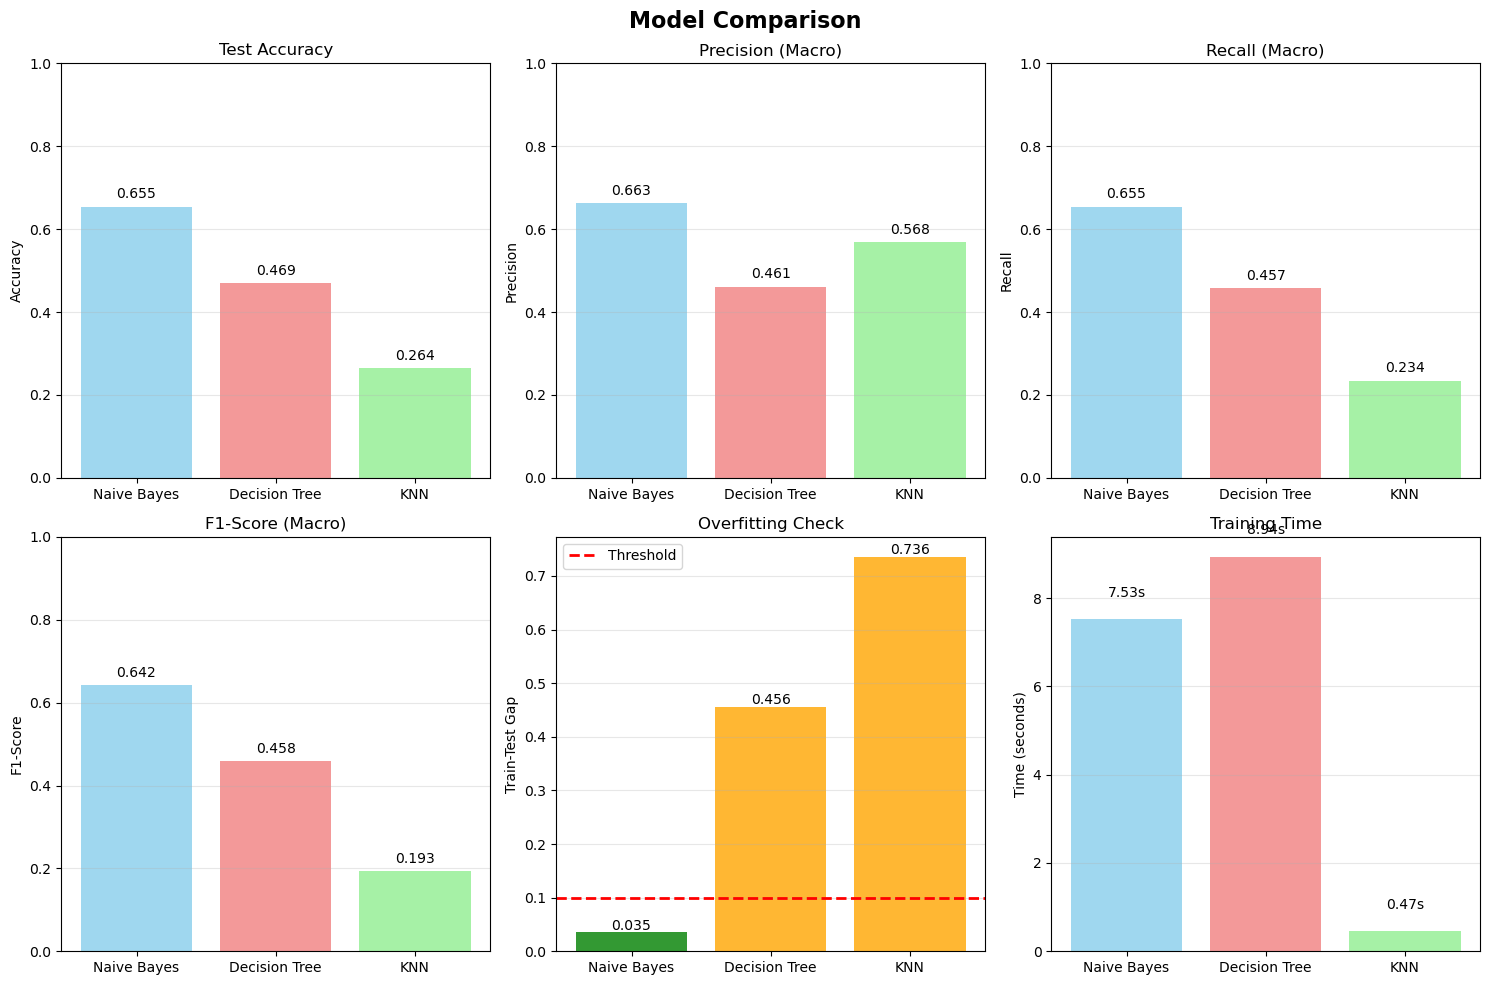

Saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\model_comparison.png

SUMMARY

Model Rankings by Test Accuracy:
  1. Naive Bayes: 0.6545
  2. Decision Tree: 0.4689
  3. KNN: 0.2639

Best Model: Naive Bayes
Lowest Overfitting: Naive Bayes
Fastest Training: KNN


In [57]:
# Get metrics for comparison
model_names = list(results.keys())
test_acc = [results[m]['test_accuracy'] for m in model_names]
precision_macro = [results[m]['precision_macro'] for m in model_names]
recall_macro = [results[m]['recall_macro'] for m in model_names]
f1_macro = [results[m]['f1_macro'] for m in model_names]
f1_weighted = [results[m]['f1_weighted'] for m in model_names]
overfit_gaps = [results[m]['overfit_gap'] for m in model_names]

# Create comparison plots
fig = plt.figure(figsize=(15, 10))

# Plot 1: Test Accuracy
ax1 = plt.subplot(2, 3, 1)
ax1.bar(model_names, test_acc, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax1.set_ylabel('Accuracy')
ax1.set_title('Test Accuracy')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(test_acc):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Plot 2: Precision
ax2 = plt.subplot(2, 3, 2)
ax2.bar(model_names, precision_macro, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax2.set_ylabel('Precision')
ax2.set_title('Precision (Macro)')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(precision_macro):
    ax2.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Plot 3: Recall
ax3 = plt.subplot(2, 3, 3)
ax3.bar(model_names, recall_macro, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax3.set_ylabel('Recall')
ax3.set_title('Recall (Macro)')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(recall_macro):
    ax3.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Plot 4: F1-Score
ax4 = plt.subplot(2, 3, 4)
ax4.bar(model_names, f1_macro, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax4.set_ylabel('F1-Score')
ax4.set_title('F1-Score (Macro)')
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(f1_macro):
    ax4.text(i, v + 0.02, f'{v:.3f}', ha='center')

# Plot 5: Overfitting Check
ax5 = plt.subplot(2, 3, 5)
colors = ['green' if gap < 0.1 else 'orange' for gap in overfit_gaps]
ax5.bar(model_names, overfit_gaps, color=colors, alpha=0.8)
ax5.set_ylabel('Train-Test Gap')
ax5.set_title('Overfitting Check')
ax5.axhline(y=0.1, color='red', linestyle='--', linewidth=2, label='Threshold')
ax5.grid(axis='y', alpha=0.3)
ax5.legend()
for i, v in enumerate(overfit_gaps):
    ax5.text(i, v + 0.005, f'{v:.3f}', ha='center')

# Plot 6: Training Time
ax6 = plt.subplot(2, 3, 6)
train_times = [training_times[m] for m in model_names]
ax6.bar(model_names, train_times, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
ax6.set_ylabel('Time (seconds)')
ax6.set_title('Training Time')
ax6.grid(axis='y', alpha=0.3)
for i, v in enumerate(train_times):
    ax6.text(i, v + 0.5, f'{v:.2f}s', ha='center')

plt.suptitle('Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {RESULTS_DIR / 'model_comparison.png'}")

# Print summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
ranked = sorted(zip(model_names, test_acc), key=lambda x: x[1], reverse=True)
print("\nModel Rankings by Test Accuracy:")
for rank, (name, acc) in enumerate(ranked, 1):
    print(f"  {rank}. {name}: {acc:.4f}")

print(f"\nBest Model: {ranked[0][0]}")
print(f"Lowest Overfitting: {model_names[np.argmin(overfit_gaps)]}")
print(f"Fastest Training: {model_names[np.argmin(train_times)]}")
print("="*60)

In [58]:
print("\n" + "="*60)
print("CLASSIFICATION REPORTS")
print("="*60)

for name, res in results.items():
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}\n")
    
    # Generate detailed report
    report = classification_report(y_test_enc, res['y_pred'], 
                                   target_names=class_names, digits=4)
    print(report)
    
    # Save report to file
    filename = f"report_{name.replace(' ', '_').lower()}.txt"
    report_path = RESULTS_DIR / filename
    
    with open(report_path, 'w') as f:
        f.write(f"Classification Report - {name}\n")
        f.write("="*60 + "\n\n")
        f.write(report)
        f.write("\n\nModel Parameters:\n")
        f.write(str(fitted[name].get_params()))
    
    print(f"Saved to: {report_path}")

print("\n" + "="*60)


CLASSIFICATION REPORTS

Naive Bayes

                       precision    recall  f1-score   support

Potato___Early_blight     0.7202    0.8067    0.7610       300
 Potato___Late_blight     0.4688    0.6500    0.5447       300
     Potato___healthy     0.9300    0.5975    0.7275       400
Tomato_Bacterial_spot     0.7758    0.7527    0.7641       639
  Tomato_Early_blight     0.3776    0.4933    0.4277       300
   Tomato_Late_blight     0.7169    0.4154    0.5260       573
       Tomato_healthy     0.6499    0.8661    0.7426       478

             accuracy                         0.6545      2990
            macro avg     0.6627    0.6545    0.6420      2990
         weighted avg     0.6887    0.6545    0.6541      2990

Saved to: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results\report_naive_bayes.txt

Decision Tree

                       precision    recall  f1-score   support

Potato___Early_blight     0.6179    0.5767    0.5966       30

In [59]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

# Find best models by different metrics
best_acc_model = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
best_f1_model = max(results.keys(), key=lambda k: results[k]['f1_macro'])
best_generalization = min(results.keys(), key=lambda k: results[k]['overfit_gap'])

print("\nBest Models:")
print(f"  Accuracy: {best_acc_model} ({results[best_acc_model]['test_accuracy']:.4f})")
print(f"  F1-Score: {best_f1_model} ({results[best_f1_model]['f1_macro']:.4f})")
print(f"  Generalization: {best_generalization} (gap: {results[best_generalization]['overfit_gap']:.4f})")

# Overall performance
print("\nOverall Performance:")
avg_acc = np.mean([results[m]['test_accuracy'] for m in results.keys()])
print(f"  Average Test Accuracy: {avg_acc:.4f}")

if avg_acc > 0.85:
    print("  Strong performance - models learned well")
elif avg_acc > 0.70:
    print("  Moderate performance - neural networks should improve this")
else:
    print("  Weak performance - need better features or deep learning")

# Check class imbalance
class_counts = [int((y_test_enc == i).sum()) for i in range(len(class_names))]
imbalance_ratio = max(class_counts) / min(class_counts)
if imbalance_ratio > 2:
    print(f"  Class imbalance ratio: {imbalance_ratio:.2f}")

print("\nFiles saved in:", RESULTS_DIR)

print("\n" + "="*60)
print("\nBaseline models (R3) completed!")


FINAL SUMMARY

Best Models:
  Accuracy: Naive Bayes (0.6545)
  F1-Score: Naive Bayes (0.6420)
  Generalization: Naive Bayes (gap: 0.0351)

Overall Performance:
  Average Test Accuracy: 0.4624
  Weak performance - need better features or deep learning
  Class imbalance ratio: 2.13

Files saved in: C:\Users\thaku\Downloads\DMML-GRP-14-main\DMML-GRP-14-main\Experiment\ImageBaseline\results


Baseline models (R3) completed!
